In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data/preprocessed_data.csv')

<AxesSubplot:>

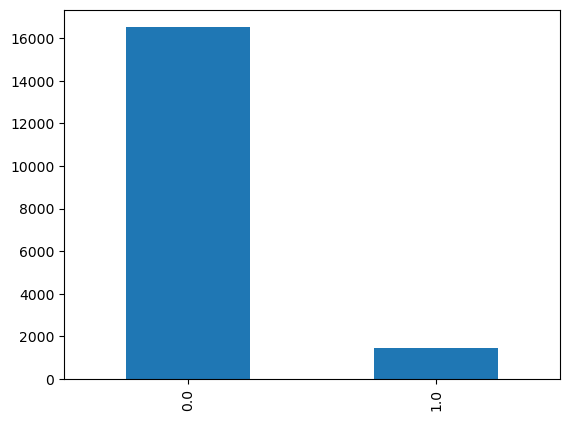

In [3]:
# 불이 안난 경우가 훨씬 많음
df['fire'].value_counts().plot.bar()

# 1. Random Undersampling

In [4]:
# 랜덤 언더샘플링으로 화재 발생하지 않은 지역 샘플링
shuffled_df = df.sample(frac=1, random_state=42)

fire_df = shuffled_df.loc[shuffled_df['fire'] != 0]
non_fire_df = shuffled_df.loc[shuffled_df['fire'] == 0][:len(fire_df)]

norm_df = pd.concat([fire_df, non_fire_df])
rand_sub_df = norm_df.sample(frac=1, random_state=42)

rand_sub_df.head()

,month,x,y,pop_rate,old_pop_rate,sto_num,barn_spwn_num,avg_temp,min_temp,max_temp,avg_hum,daily_pre,avg_wind,field_fire,green_fire,fire
8437,3,0.071429,0.714286,0.040054,0.092166,0.075472,0.000000,0.303109,0.292011,0.371359,0.439338,0.010695,0.272727,0.071429,0.071429,0.0
11705,3,0.142857,0.357143,0.038427,0.086070,0.207547,0.000000,0.295337,0.283747,0.393204,0.560662,0.000000,0.212121,0.000000,0.000000,1.0
3015,11,0.214286,0.857143,0.024252,0.066975,0.000000,0.000000,0.544041,0.528926,0.580097,0.584559,0.000000,0.151515,0.000000,0.000000,0.0
17879,12,0.500000,0.642857,1.000000,1.000000,0.981132,0.333333,0.121762,0.143251,0.092233,0.104779,0.000000,0.242424,0.357143,0.357143,1.0
17513,9,0.857143,0.571429,0.104754,0.165997,0.471698,0.333333,0.759067,0.823691,0.737864,0.753676,0.000000,0.151515,0.071429,0.071429,1.0


<AxesSubplot:>

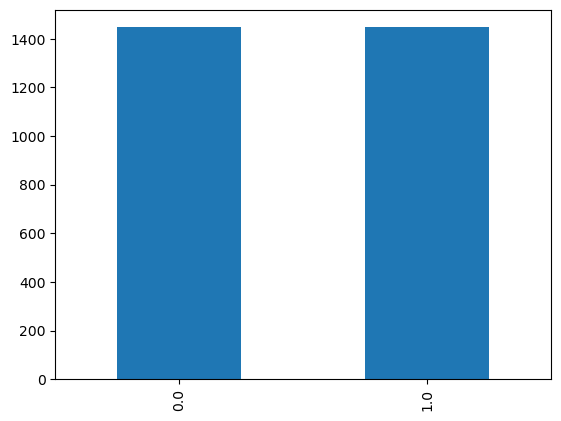

In [5]:
# 불이 난 경우와 안난 경우가 같아짐
rand_sub_df['fire'].value_counts().plot.bar()

<AxesSubplot:>

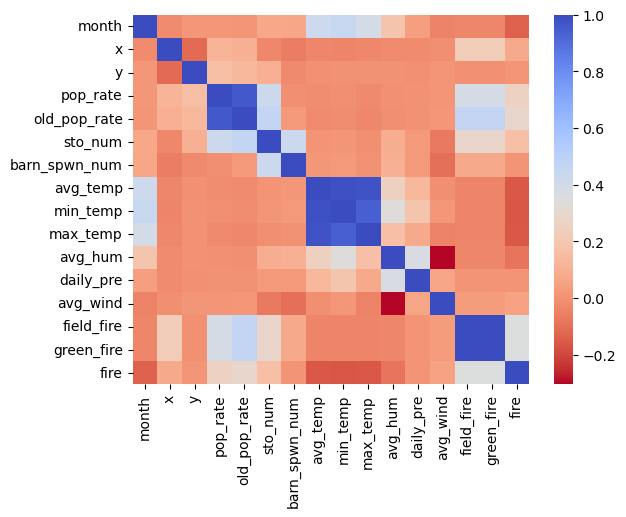

In [6]:
# 변수별 상관관계 분석
corr = rand_sub_df.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [7]:
# 변수별 상관관계 조사
corr['fire'].sort_values(ascending=False)

fire             1.000000
field_fire       0.350398
green_fire       0.350398
old_pop_rate     0.290467
pop_rate         0.253521
sto_num          0.161138
x                0.077616
avg_wind         0.047629
y                0.010616
daily_pre        0.005192
barn_spwn_num    0.001956
avg_hum         -0.087642
month           -0.141189
max_temp        -0.156878
avg_temp        -0.160180
min_temp        -0.163089
Name: fire, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score

In [9]:
# train, test 데이터 스플릿
X = rand_sub_df.drop('fire', axis=1)
y = rand_sub_df['fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 모델 기본 파라미터로 학습
classifiers = {
    "로지스틱회귀": LogisticRegression(),
    "K최근접": KNeighborsClassifier(),
    "결정트리": DecisionTreeClassifier(),
    "랜덤포레스트": RandomForestClassifier()
}

for _, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "에서 학습 정확도", round(training_score.mean(), 2) * 100, "%")

LogisticRegression 에서 학습 정확도 68.0 %
KNeighborsClassifier 에서 학습 정확도 64.0 %
DecisionTreeClassifier 에서 학습 정확도 59.0 %
RandomForestClassifier 에서 학습 정확도 66.0 %


In [11]:
# 로지스틱회귀 하이퍼파라미터 튜닝
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid = GridSearchCV(LogisticRegression(), lr_params)
lr_grid.fit(X_train, y_train)
lr_best = lr_grid.best_estimator_

print('최고예측정확도: {:.2f}%'.format(lr_grid.best_score_ * 100), '파라미터:', lr_grid.best_params_)
# 최고예측정확도: 68.03% 파라미터: {'C': 10, 'penalty': 'l2'}

최고예측정확도: 68.03% 파라미터: {'C': 10, 'penalty': 'l2'}


In [12]:
# K최근접 하이퍼파라미터 튜닝
kn_params = {"n_neighbors": [2, 3, 4], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

kn_grid = GridSearchCV(KNeighborsClassifier(), kn_params)
kn_grid.fit(X_train, y_train)
kn_best = kn_grid.best_estimator_

print('최고예측정확도: {:.2f}%'.format(kn_grid.best_score_ * 100), '파라미터:', kn_grid.best_params_)
# 최고예측정확도: 62.20% 파라미터: {'algorithm': 'auto', 'n_neighbors': 4}

최고예측정확도: 62.20% 파라미터: {'algorithm': 'auto', 'n_neighbors': 4}


In [13]:
# 결정트리 하이퍼파라미터 튜닝
dt_params = {"criterion": ["gini", "entropy"], "max_depth": [2, 3, 4, 5], "min_samples_leaf": [5, 6, 7, 8, 9]}

dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

print('최고예측정확도: {:.2f}%'.format(dt_grid.best_score_ * 100), '파라미터:', dt_grid.best_params_)
# 최고예측정확도: 66.65% 파라미터: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}

최고예측정확도: 66.65% 파라미터: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}


In [29]:
# 랜덤포레스트 하이퍼파라미터 튜닝
rf_params = { 'n_estimators' : [100], 'max_depth' : [4, 6, 8], 'min_samples_leaf' : [8, 12, 18, 20], 'min_samples_split' : [6, 8, 16]}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print('최고예측정확도: {:.2f}%'.format(rf_grid.best_score_ * 100), '파라미터:', rf_grid.best_params_)
# 최고예측정확도: 69.03% 파라미터: {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}

최고예측정확도: 69.03% 파라미터: {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [30]:
# 모델 알고리즘 f1 스코어 cross validation
lr_score_f1 = cross_val_score(lr_best, X_train, y_train, scoring='f1', cv=5)
kn_score_f1 = cross_val_score(kn_best, X_train, y_train, scoring='f1', cv=5)
dt_score_f1 = cross_val_score(dt_best, X_train, y_train, scoring='f1', cv=5)
rf_score_f1 = cross_val_score(rf_best, X_train, y_train, scoring='f1', cv=5)

print('로지스틱 회귀 F1 스코어: {:.2f}%'.format(lr_score_f1.mean() * 100))
print('K최근접 F1 스코어: {:.2f}%'.format(kn_score_f1.mean() * 100))
print('결정트리 F1 스코어: {:.2f}%'.format(dt_score_f1.mean() * 100))
print('랜덤포레스트 F1 스코어: {:.2f}%'.format(rf_score_f1.mean() * 100))

로지스틱 회귀 F1 스코어: 65.95%
K최근접 F1 스코어: 54.73%
결정트리 F1 스코어: 64.63%
랜덤포레스트 F1 스코어: 68.83%


In [33]:
# 모델 알고리즘 ROC AUC 스코어 cross validation
lr_pred = cross_val_predict(lr_best, X_train, y_train, cv=5, method="decision_function")
kn_pred = cross_val_predict(kn_best, X_train, y_train, cv=5)
dt_pred = cross_val_predict(dt_best, X_train, y_train, cv=5)
rf_pred = cross_val_predict(rf_best, X_train, y_train, cv=5)

print('로지스틱 회귀 ROC AUC 스코어: {:.5f}'.format(roc_auc_score(y_train, lr_pred)))
print('K최근접 ROC AUC 스코어: {:.5f}'.format(roc_auc_score(y_train, kn_pred)))
print('결정트리 ROC AUC 스코어: {:.5f}'.format(roc_auc_score(y_train, dt_pred)))
print('랜덤포레스트 ROC AUC 스코어: {:.5f}'.format(roc_auc_score(y_train, rf_pred)))

로지스틱 회귀 ROC AUC 스코어: 0.74664
K최근접 ROC AUC 스코어: 0.62058
결정트리 ROC AUC 스코어: 0.66611
랜덤포레스트 ROC AUC 스코어: 0.68555


Undersampling에서는 로지스틱 회귀가 적절해보임

# 2. SMOTE Oversampling

In [16]:
# 데이터를 X, y로 분류
skfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
near_sub_X = df.drop('fire', axis=1)
near_sub_y = df.loc[:, ['fire']]

for train_idx, test_idx in skfold.split(near_sub_X, near_sub_y):
    near_sub_X_train = near_sub_X.iloc[train_idx]
    near_sub_X_test = near_sub_X.iloc[test_idx]
    near_sub_y_train = near_sub_y.iloc[train_idx]
    near_sub_y_test = near_sub_y.iloc[test_idx]

near_sub_X_train = near_sub_X_train.values
near_sub_X_test = near_sub_X_test.values
near_sub_y_train = near_sub_y_train.values
near_sub_y_test = near_sub_y_test.values

In [20]:
# NearMiss 방법으로 Undersampling
near_acc = []
near_prec = []
near_recall = []
near_f1 = []
near_auc = []

near_X, near_y = NearMiss().fit_resample(near_sub_X.values, near_sub_y.values)

for train, test in skfold.split(near_sub_X_train, near_sub_y_train):
    pipeline = make_pipeline(NearMiss(), rf_best)
    model = pipeline.fit(near_sub_X_train[train], near_sub_y_train[train])
    pred = model.predict(near_sub_X_train[test])
    
    near_acc.append(pipeline.score(near_sub_X_train[test], near_sub_y_train[test]))
    near_prec.append(precision_score(near_sub_y_train[test], pred))
    near_recall.append(recall_score(near_sub_y_train[test], pred))
    near_f1.append(f1_score(near_sub_y_train[test], pred))
    near_auc.append(roc_auc_score(near_sub_y_train[test], pred))

In [26]:
near_f1

[0.2402957486136784,
 0.19938650306748465,
 0.16049382716049385,
 0.16442451420029894,
 0.1665943600867679]